<a href="https://colab.research.google.com/github/alongstar518/cs221_finalproject/blob/master/base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Steel Defect Detection 


Architecture of Model is U-Net with pretrained encoder. In our case it ResNet18.

![](https://github.com/ushur/Severstal-Steel-Defect-Detection/blob/master/unet.jpg?raw=true)

### Import necessary libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from tqdm import tqdm_notebook
import cv2
from PIL import Image
import shutil

import torch
import torch.nn as nn
import torch.optim as optim 
import torchvision
from torchvision import models
from torch.utils.data import DataLoader, Dataset
import torch.utils.data as utils
from torchvision import transforms
import torch.nn.functional as F

### Print some basic information

In [3]:
print(torch.__version__)
print("Cuda device avaliablity: {}".format(torch.cuda.is_available()))
print("Cuda device name: {}".format(torch.cuda.get_device_name()))
print("Cuda device Capilibility: {}".format(
    torch.cuda.get_device_capability(device=None)
  )
)

1.3.0+cu100
Cuda device avaliablity: True
Cuda device name: Tesla K80
Cuda device Capilibility: (3, 7)


### basic config

In [0]:
reload_data = True
path = "your local path here if you do not run on colab"
data_path = "/content/drive/My Drive/share" # path to data on google drive

### download data

In [4]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  data_zip_path = os.path.join(data_path, "severstal-steel-defect-detection.zip")
  data_zip_path_dst = "/content/severstal-steel-defect-detection.zip"
  path = os.path.join("/content/data")

  if reload_data:
    print("Copy raw data from {} to {}".format(data_zip_path, data_zip_path_dst))
    shutil.copy(data_zip_path, "/content")

    print("unzip raw data...")
    os.system("unzip {} -d {}".format(data_zip_path_dst, path))
    
    print("give back missing permissions for unzipping")
    os.system(
      "chmod +wrx /content/data/train_images.zip /content/data/test_images.zip"
    )
    
    print("unzipping data...")
    os.system("unzip {} -d {}".format(
        os.path.join(path,"train_images.zip"), 
        os.path.join(path,"train_images")
        )
    )
    os.system("unzip {} -d {}".format(
        os.path.join(path,"test_images.zip"), 
        os.path.join(path,"test_images")
      )
    )
    on_colab = True
except:
  on_colab = False

!ls /content/data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Copy raw data from /content/drive/My Drive/share/severstal-steel-defect-detection.zip to /content/severstal-steel-defect-detection.zip
unzip raw data...
give back missing permissions for unzipping
unzipping data...
sample_submission.csv  test_images.zip	train_images
test_images	       train.csv	train_images.zip


### hyperparamters

In [0]:
batch_size = 32
weight_decay=1e-4 
lr = 0.001
momentum=0.9

In [0]:
#!unzip "/content/drive/My Drive/share/severstal-steel-defect-detection.zip" -d "/content/drive/My Drive/share/cs221data/"
#!ls -la "/content/drive/My Drive/share/cs221data"
#!chmod +wrx "/content/drive/My Drive/share/cs221data/test_images.zip" "/content/drive/My Drive/share/cs221data/train_images.zip"
#!unzip "/content/drive/My Drive/share/cs221data/test_images.zip" -d "/content/drive/My Drive/share/cs221data/test_images"
#!unzip "/content/drive/My Drive/share/cs221data/train_images.zip" -d "/content/drive/My Drive/share/cs221data/train_images"

In [7]:
tr = pd.read_csv(os.path.join(path, 'train.csv'))
print(len(tr))
tr.head()

50272


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


#### To simplify and speed up process, n this kernel I use only images with ClassId=4

In [8]:
df_train = tr[tr['EncodedPixels'].notnull()].reset_index(drop=True)
print(len(df_train))
df_train.head()

7095


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0007a71bf.jpg_3,18661 28 18863 82 19091 110 19347 110 19603 11...
2,000a4bcdd.jpg_1,37607 3 37858 8 38108 14 38359 20 38610 25 388...
3,000f6bf48.jpg_4,131973 1 132228 4 132483 6 132738 8 132993 11 ...
4,0014fce06.jpg_3,229501 11 229741 33 229981 55 230221 77 230468...


### Decode mask

In [0]:
def rle2mask(rle, imgshape):
    width = imgshape[0]
    height= imgshape[1]
    
    mask= np.zeros( width*height ).astype(np.uint8)
    
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
        current_position += lengths[index]
        
    return np.flipud( np.rot90( mask.reshape(height, width), k=1 ) )

### Display some images

error: ignored

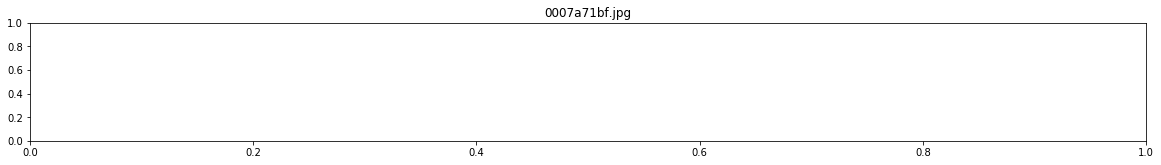

In [10]:
columns = 1
rows = 4
fig = plt.figure(figsize=(20,columns*rows+6))
for i in range(1,columns*rows+1):
    fn = df_train['ImageId_ClassId'].str[:-2].iloc[i]
    fig.add_subplot(rows, columns, i).set_title(fn)
    img = cv2.imread( path + 'train_images/'+fn )
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    mask = rle2mask(df_train['EncodedPixels'].iloc[i], (256, 1600))
    img[mask==1,0] = 255
    plt.imshow(img)
plt.show()

### Create train Dataset and DataLoader

In [0]:
class ImageData(Dataset):
    def __init__(self, df, transform, subset="train"):
        super().__init__()
        self.df = df
        self.transform = transform
        self.subset = subset
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):                      
        fn = self.df['ImageId_ClassId'].iloc[index].split('_')[0]         
        img = Image.open(self.data_path + fn)
        img = self.transform(img)

        if self.subset == 'train': 
            mask = rle2mask(self.df['EncodedPixels'].iloc[index], (256, 1600))
            mask = transforms.ToPILImage()(mask)            
            mask = self.transform(mask)
            return img, mask
        else: 
            mask = None
            return img       

In [0]:
data_transf = transforms.Compose([
                                  transforms.Resize((256, 256)),
                                  transforms.ToTensor()])
train_data = ImageData(df = df_train, transform = data_transf)
train_loader = DataLoader(dataset = train_data, batch_size=batch_size)

### Show some image and mask

In [0]:
plt.imshow(train_data[3][0].permute(1, 2, 0))

In [0]:
plt.imshow(np.squeeze(train_data[3][1].permute(1, 2, 0)))

### Create U-Net Model

In [0]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18()
        self.base_model.load_state_dict(torch.load(os.path.join(
            path, "resnet18/resnet18.pth"))
        )
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3])
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5])
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(
            scale_factor=2, mode='bilinear', align_corners=True
            )

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out

In [0]:
model = UNet(n_class=1).cuda()
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(
    model.parameters(), weight_decay=weight_decay, lr = lr, momentum=momentum
  )

### Training

In [0]:
for epoch in range(5):      
    model.train()
    with tqdm_notebook(total=len(train_loader.dataset)) as pbar:         
      for ii, (data, target) in enumerate(train_loader):                         
          data, target = data.cuda(), target.cuda()
          optimizer.zero_grad()
          output = model(data)
          loss = criterion(output, target)
          loss.backward()
          optimizer.step()
          pbar.update(len(data))
          pbar.set_postfix(epoch=epoch, loss=loss.item())          
    print('Epoch summary: {} - Loss: {:.6f}'.format(epoch + 1, loss.item()))

### Show prediction on image from train dataset

In [0]:
plt.imshow(train_data[6][0].permute(1, 2, 0))

In [0]:
x = train_data[6][0].unsqueeze(0)
o = model(x.cuda())  
o = o.cpu().detach().numpy() * (-1)
tmp = np.copy(o)
mn = np.mean(o)*1.2
tmp[tmp<mn] = 0
tmp[tmp>mn] = 1
plt.imshow(np.squeeze(tmp))

### Read submit file

In [0]:
submit = pd.read_csv(path + 'sample_submission.csv', converters={'EncodedPixels': lambda e: ' '})
print(len(submit))
sub4 = submit[submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')]
print(len(sub4))
sub4.head()

### Create test Dataset and DataLoader

In [0]:
test_data = ImageData(df = sub4, transform = data_transf, subset="test")
test_loader = DataLoader(dataset = test_data, shuffle=False)

### Prediction

In [0]:
%%time
predict = []
model.eval()
for data in test_loader:
    data = data.cuda()
    output = model(data)  
    output = output.cpu().detach().numpy() * (-1)    
    predict.append(abs(output[0]))

### Encode mask 

In [0]:
def mask2rle(img):
    tmp = np.rot90( np.flipud( img ), k=3 )
    rle = []
    lastColor = 0;
    startpos = 0
    endpos = 0

    tmp = tmp.reshape(-1,1)   
    for i in range( len(tmp) ):
        if (lastColor==0) and tmp[i]>0:
            startpos = i
            lastColor = 1
        elif (lastColor==1)and(tmp[i]==0):
            endpos = i-1
            lastColor = 0
            rle.append( str(startpos)+' '+str(endpos-startpos+1) )
    return " ".join(rle)

### Resize images

In [0]:
%%time
pred_rle = []
  
for p in predict:        
    img = np.copy(p)
    mn = np.mean(img)*1.2
    img[img<=mn] = 0
    img[img>mn] = 1
    img = cv2.resize(img[0], (1600, 256))
    
    pred_rle.append(mask2rle(img))

### Prepare submission file

In [0]:
submit['EncodedPixels'][submit['ImageId_ClassId'].apply(lambda x: x.split('_')[1] == '4')] = pred_rle
submit.head()

In [0]:
img_s = cv2.imread( path + 'test_images/'+ submit['ImageId_ClassId'][47].split('_')[0])
plt.imshow(img_s)

In [0]:
mask_s = rle2mask(submit['EncodedPixels'][47], (256, 1600))
plt.imshow(mask_s)

In [0]:
submit.head(10)

In [0]:
submit.to_csv('submission.csv', index=False)